In [1]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import libsvm
from libsvm.svmutil import *

from PIL import Image

In [2]:
### Data processing

def read_image(dirpath):
    image_data = []
    
    for file in os.listdir(dirpath):
        if os.path.isfile(os.path.join(dirpath, file)):
            c = os.path.basename(file)
            filename = dirpath + '/' + c
            image = Image.open(filename).resize((32, 32)).convert('L')
            image_arr = np.array(image).reshape(1, 1024)
            image_data.append(image_arr)
    
    return image_data

def process_image(folderpath):
    data_all = []
    for i in range(1, 26):
        ### '/home/x/PR_CA/PIE/'
        dirpath = folderpath + str(i)  
        image_list = read_image(dirpath)
        data_image = np.concatenate(image_list, axis=0)
        data_all.append(data_image)
    return data_all
    
def train_test_split(data, label):
    proportion = 0.7
    lens = data.shape[0]
    print(lens)
    idx = random.sample(range(0, lens), int(proportion*lens))
    idx = sorted(idx)
    
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(lens):
        if i in idx:
            train_x.append(data[i].reshape(1, -1))
            train_y.append(label[i].reshape(1, -1))
        else:
            test_x.append(data[i].reshape(1, -1))
            test_y.append(label[i].reshape(1, -1))
    
#     train_x = [data[i].reshape(1, -1) for i in idx]
#     train_y = [label[i].reshape(1, -1) for i in idx]
#     test_x = [data[i].reshape(1, -1) for i in range(lens) if i not in idx]
#     test_y = [label[i].reshape(1, -1) for i in range(lens) if i not in idx]
    
    trainx = np.concatenate(train_x)
    trainy = np.concatenate(train_y)
    testx = np.concatenate(test_x)
    testy = np.concatenate(test_y)
    return trainx, trainy, testx, testy



In [3]:
### LDA
def LDA_(data_pro, n_component):
    data_x = data_pro[0] - data_pro[0].mean(0)
    data_y = data_pro[1]
    N_sample, Fea = data_x.shape
    
    # Sw
    classes = np.unique(data_y)
    Sw = np.zeros([Fea, Fea])
    for i in classes:
        data_i = data_x[data_y == i]
        data_i = data_i - data_i.mean(0)
        data_i_var = np.dot(np.mat(data_i).T, np.mat(data_i))
        Sw += data_i_var
        
    #Sb
    u = data_x.mean(0)
    Sb = np.zeros([Fea, Fea])
    for i in classes:
        N_i = data_x[data_y==i].shape[0]
        u_i = data_x[data_y==i].mean(0)
        data_i = u_i - u

        data_var = N_i * np.dot(np.mat(data_i).T, np.mat(data_i))
        Sb += data_var
        
    S = np.dot(np.linalg.inv(Sw), Sb)
    
    eig_val, eig_vec = np.linalg.eig(S)

    eig_val_idx = np.argsort(-eig_val)
    
    feature = eig_vec[:, eig_val_idx[0:n_component]]
    data = np.dot(data_x, feature)
    
    return np.real(data)

In [4]:
def LDA_Split(image_all, label_image, self_image, label_self, n_component):
    image_all = LDA_([image_all, label_image], n_component)
    self_image = LDA_([self_image, label_self], n_component)
    trainx, trainy, testx, testy = train_test_split(image_all, label_image)
    trainx_self, trainy_self, testx_self, testy_self = train_test_split(self_image, label_self)

    # Training data and testing data
    train_x = np.concatenate([trainx, trainx_self])
    train_y = np.concatenate([trainy, trainy_self])
    test_x = np.concatenate([testx, testx_self])
    test_y = np.concatenate([testy, testy_self])
    data_pro = [train_x, train_y, test_x, test_y]
    return data_pro

In [5]:
### Data

folderpath = 'PIE/'
data_all = process_image(folderpath)
image_all = np.concatenate(data_all)
label_image = np.arange(0, 25, 1).repeat(170)

self_folder = 'PIE/0'
self_image = np.concatenate(read_image(self_folder))
label_self = np.array([25]).repeat(10)

trainx, trainy, testx, testy = train_test_split(image_all, label_image)
trainx_self, trainy_self, testx_self, testy_self = train_test_split(self_image, label_self)

# Training data and testing data
train_x = np.concatenate([trainx, trainx_self])
train_y = np.concatenate([trainy, trainy_self])
test_x = np.concatenate([testx, testx_self])
test_y = np.concatenate([testy, testy_self])

data_lda_2 = LDA_Split(image_all, label_image, self_image, label_self, 2)
data_lda_3 = LDA_Split(image_all, label_image, self_image, label_self, 3)
data_lda_9 = LDA_Split(image_all, label_image, self_image, label_self, 9)

4250
10
4250
10
4250
10
4250
10


In [6]:
### NN

def Nearest_Neighbor(data_pro):
    train_x = data_pro[0]
    train_y = data_pro[1]
    test_x = data_pro[2]
    test_y = data_pro[3]
    lens_train = train_x.shape[0]
    lens_test = test_x.shape[0]
    
    # calculating distance
    res = []
    for i in range(lens_test):
        distances = []
        for j in range(lens_train):
            distance = np.linalg.norm(test_x[i] - train_x[j])
            distances.append([distance, train_y[j]])
        nearest_group = [i[1] for i in sorted(distances)]
        res.append(nearest_group[0])
    
    return np.array(res)
       

In [7]:
def NN_LDA(data_pro):
    res = Nearest_Neighbor(data_pro).reshape(1, -1)
    label = data_pro[3].reshape(1, -1)
    lens = res.shape[1]
    
    acc1 = np.sum(res[0, :-3]==label[0, :-3]) / (lens-3)

    acc2 = np.sum(res[0, -3:]==label[0, -3:]) / 3
    
    print("Accuracy on CMU dataset is: ", acc1)
    print("Accuracy on Self_image is: ", acc2)
    
    print("The classification result is: ")
    print(res)
    print("\n")


In [8]:
print("LDA_NN classification")
print("Dimension of processed data is 2")
NN_LDA(data_lda_2)

print("Dimension of processed data is 3")
NN_LDA(data_lda_3)

print("Dimension of processed data is 9")
NN_LDA(data_lda_9)


LDA_NN classification
Dimension of processed data is 2
Accuracy on CMU dataset is:  0.47294117647058825
Accuracy on Self_image is:  0.3333333333333333
The classification result is: 
[[12  0 17 ... 25  1  3]]


Dimension of processed data is 3
Accuracy on CMU dataset is:  0.796078431372549
Accuracy on Self_image is:  0.6666666666666666
The classification result is: 
[[ 0 12  0 ... 25 25  9]]


Dimension of processed data is 9
Accuracy on CMU dataset is:  0.9945098039215686
Accuracy on Self_image is:  0.3333333333333333
The classification result is: 
[[ 0  0  0 ...  3 16 25]]




The number of selfie image is:  2


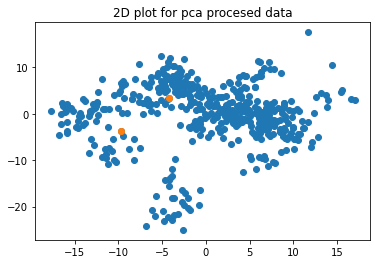

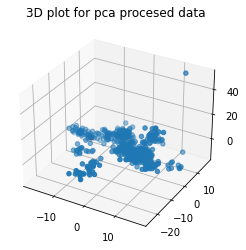

In [38]:
### LDA plot
def LDA_plot(data, label): ##origin_image_data
    lens = data.shape[0]
    num_sample = 500
    idx = random.sample(range(0, lens), num_sample)
    
    data_plot = [data[i].reshape(1, -1) for i in idx]
    data_plot = np.concatenate(data_plot)
    label_plot = [label[i] for i in idx]
    label_plot = np.array(label_plot)
    
    self_data = sum(i>=2975 for i in idx)
    print("The number of selfie image is: ",self_data)
    
    data2 = LDA_([data_plot, label_plot], 2)
    
    dx = data2[:, 0]
    dy = data2[:, 1]
    plt.scatter(dx, dy)
    
    if(self_data != 0):
        plt.scatter(data2[-self_data:, 0], data2[-self_data:, 1])
    plt.title("2D plot for pca procesed data")
    plt.show()
    
#     model_pca3 = PCA(n_components=3)
#     model_pca3.fit(data_plot)
#     data3 = model_pca3.transform(data_plot)
    data3 = LDA_([data_plot, label_plot], 3)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(data3[:, 0], data3[:, 1], data3[:, 2])
    
    if(self_data != None):
        ax.scatter3D(data3[-self_data:, 0], data3[-self_data:, 1], data3[-self_data:, 2], c='red')
    plt.title("3D plot for pca procesed data")
    plt.show()
    
# LDA_plot(data_lda_2[0], train_y.reshape(1, -1)[0])
LDA_plot(data_lda_3[0], data_lda_3[1].reshape(1, -1)[0])

In [40]:
print(data_lda_2[0])
print(data_lda_3[0])
print(data_lda_9[0])

[[  4.20011817  -5.75470247]
 [  7.17484899  -4.60429536]
 [  5.43490528  -5.11759323]
 ...
 [-15.1         13.3       ]
 [-15.1        -26.7       ]
 [-22.1         -7.7       ]]
[[  5.8405534   -3.68067123   2.88123891]
 [  4.20011817  -5.75470247   2.56770936]
 [  7.17484899  -4.60429536   3.54389837]
 ...
 [-15.1         13.3          0.7       ]
 [-22.1         -7.7         -3.3       ]
 [  6.9         14.3         11.7       ]]
[[  5.8405534   -3.68067123   2.88123891 ...   1.99870952  -3.26603872
   -2.06192677]
 [  4.20011817  -5.75470247   2.56770936 ...   3.94129343  -8.14421095
   -2.06049809]
 [  7.17484899  -4.60429536   3.54389837 ...   3.90264158  -8.4832897
   -3.80273783]
 ...
 [-15.1         13.3          0.7        ...  -0.1         -1.1
   -1.6       ]
 [-15.1        -26.7         -4.3        ...   2.9          9.9
   15.4       ]
 [  6.9         14.3         11.7        ... -28.1        -36.1
    0.4       ]]
